In [36]:
%load_ext autoreload
%autoreload 2

loading /Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/inflaton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/inflaton/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
Encoder model frozen.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/inflaton/anaconda3/envs/rapget/lib/python3.11/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [37]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/papers/rapget-translation


In [38]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/papers/rapget-translation/.env


True

In [39]:
import os

model_name = os.getenv("MODEL_NAME")
adapter_name_or_path = os.getenv("ADAPTER_NAME_OR_PATH")
load_in_4bit = os.getenv("LOAD_IN_4BIT") == "true"
data_path = os.getenv("DATA_PATH")
results_path = "results/mac-results_few_shots.csv"  # os.getenv("RESULTS_PATH")
metrics_csv = results_path.replace(".csv", "_metrics.csv")
use_english_datasets = os.getenv("USE_ENGLISH_DATASETS") == "true"
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))
recalculate = os.getenv("RECALCULATE") == "true"

print("recalculate:", recalculate)

print(model_name, data_path, results_path, metrics_csv, max_new_tokens)

recalculate: False
Qwen/Qwen2-7B-Instruct datasets/mac/mac.tsv results/mac-results_few_shots.csv results/mac-results_few_shots_metrics.csv 300


In [40]:
import pandas as pd
from llm_toolkit.llm_utils import *
from llm_toolkit.translation_utils import *

df = pd.read_csv(results_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 44 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   chinese                                             1133 non-null   object
 1   english                                             1133 non-null   object
 2   Qwen/Qwen2-72B-Instruct/shots-00                    1133 non-null   object
 3   Qwen/Qwen2-72B-Instruct/shots-01                    1133 non-null   object
 4   Qwen/Qwen2-72B-Instruct/shots-03                    1133 non-null   object
 5   Qwen/Qwen2-72B-Instruct/shots-05                    1133 non-null   object
 6   Qwen/Qwen2-72B-Instruct/shots-10                    1133 non-null   object
 7   Qwen/Qwen2-72B-Instruct/shots-50                    1133 non-null   object
 8   Qwen/Qwen2-7B-Instruct/shots-00                     1133 non-null   object
 9   Qwen/Qwe

In [41]:
df_openai = pd.read_csv("results/mac-results_few_shots_openai.csv")
df_openai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   chinese                1133 non-null   object
 1   english                1133 non-null   object
 2   gpt-4o-mini/shots-00   1133 non-null   object
 3   gpt-4o-mini/shots-01   1133 non-null   object
 4   gpt-4o-mini/shots-03   1133 non-null   object
 5   gpt-4o-mini/shots-05   1133 non-null   object
 6   gpt-4o-mini/shots-10   1133 non-null   object
 7   gpt-4o-mini/shots-50   1133 non-null   object
 8   gpt-4o/shots-00        1133 non-null   object
 9   gpt-4o/shots-01        1133 non-null   object
 10  gpt-4o/shots-03        1133 non-null   object
 11  gpt-4o/shots-05        1133 non-null   object
 12  gpt-4o/shots-10        1133 non-null   object
 13  gpt-4o/shots-50        1133 non-null   object
 14  gpt-4o-mini/epochs-01  1133 non-null   object
 15  gpt-4o-mini/epochs-02

In [42]:
openai_cols = df_openai.columns[2:].tolist()
openai_cols = [col for col in openai_cols if "shots" in col]
openai_cols

['gpt-4o-mini/shots-00',
 'gpt-4o-mini/shots-01',
 'gpt-4o-mini/shots-03',
 'gpt-4o-mini/shots-05',
 'gpt-4o-mini/shots-10',
 'gpt-4o-mini/shots-50',
 'gpt-4o/shots-00',
 'gpt-4o/shots-01',
 'gpt-4o/shots-03',
 'gpt-4o/shots-05',
 'gpt-4o/shots-10',
 'gpt-4o/shots-50']

In [43]:
result_columns = df.columns[2:].to_list()
result_columns.sort()
result_columns

['Qwen/Qwen2-72B-Instruct/shots-00',
 'Qwen/Qwen2-72B-Instruct/shots-01',
 'Qwen/Qwen2-72B-Instruct/shots-03',
 'Qwen/Qwen2-72B-Instruct/shots-05',
 'Qwen/Qwen2-72B-Instruct/shots-10',
 'Qwen/Qwen2-72B-Instruct/shots-50',
 'Qwen/Qwen2-7B-Instruct/shots-00',
 'Qwen/Qwen2-7B-Instruct/shots-01',
 'Qwen/Qwen2-7B-Instruct/shots-03',
 'Qwen/Qwen2-7B-Instruct/shots-05',
 'Qwen/Qwen2-7B-Instruct/shots-10',
 'Qwen/Qwen2-7B-Instruct/shots-50',
 'internlm/internlm2_5-7b-chat/shots-00',
 'internlm/internlm2_5-7b-chat/shots-01',
 'internlm/internlm2_5-7b-chat/shots-03',
 'internlm/internlm2_5-7b-chat/shots-05',
 'internlm/internlm2_5-7b-chat/shots-10',
 'internlm/internlm2_5-7b-chat/shots-50',
 'microsoft/Phi-3.5-mini-instruct/shots-00',
 'microsoft/Phi-3.5-mini-instruct/shots-01',
 'microsoft/Phi-3.5-mini-instruct/shots-03',
 'microsoft/Phi-3.5-mini-instruct/shots-05',
 'microsoft/Phi-3.5-mini-instruct/shots-10',
 'microsoft/Phi-3.5-mini-instruct/shots-50',
 'shenzhi-wang/Llama3.1-70B-Chinese-Chat

In [44]:
columns = df.columns[:2].to_list() + result_columns
df = df[columns]

In [45]:
df[openai_cols] = df_openai[openai_cols]
columns = df.columns.to_list()
result_columns = df.columns[2:].to_list()
result_columns, columns

(['Qwen/Qwen2-72B-Instruct/shots-00',
  'Qwen/Qwen2-72B-Instruct/shots-01',
  'Qwen/Qwen2-72B-Instruct/shots-03',
  'Qwen/Qwen2-72B-Instruct/shots-05',
  'Qwen/Qwen2-72B-Instruct/shots-10',
  'Qwen/Qwen2-72B-Instruct/shots-50',
  'Qwen/Qwen2-7B-Instruct/shots-00',
  'Qwen/Qwen2-7B-Instruct/shots-01',
  'Qwen/Qwen2-7B-Instruct/shots-03',
  'Qwen/Qwen2-7B-Instruct/shots-05',
  'Qwen/Qwen2-7B-Instruct/shots-10',
  'Qwen/Qwen2-7B-Instruct/shots-50',
  'internlm/internlm2_5-7b-chat/shots-00',
  'internlm/internlm2_5-7b-chat/shots-01',
  'internlm/internlm2_5-7b-chat/shots-03',
  'internlm/internlm2_5-7b-chat/shots-05',
  'internlm/internlm2_5-7b-chat/shots-10',
  'internlm/internlm2_5-7b-chat/shots-50',
  'microsoft/Phi-3.5-mini-instruct/shots-00',
  'microsoft/Phi-3.5-mini-instruct/shots-01',
  'microsoft/Phi-3.5-mini-instruct/shots-03',
  'microsoft/Phi-3.5-mini-instruct/shots-05',
  'microsoft/Phi-3.5-mini-instruct/shots-10',
  'microsoft/Phi-3.5-mini-instruct/shots-50',
  'shenzhi-wang/

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 56 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   chinese                                             1133 non-null   object
 1   english                                             1133 non-null   object
 2   Qwen/Qwen2-72B-Instruct/shots-00                    1133 non-null   object
 3   Qwen/Qwen2-72B-Instruct/shots-01                    1133 non-null   object
 4   Qwen/Qwen2-72B-Instruct/shots-03                    1133 non-null   object
 5   Qwen/Qwen2-72B-Instruct/shots-05                    1133 non-null   object
 6   Qwen/Qwen2-72B-Instruct/shots-10                    1133 non-null   object
 7   Qwen/Qwen2-72B-Instruct/shots-50                    1133 non-null   object
 8   Qwen/Qwen2-7B-Instruct/shots-00                     1133 non-null   object
 9   Qwen/Qwe

In [47]:
%%time

variant = "shots"
if recalculate:
    metrics_df = None
else:
    metrics_df = pd.read_csv(metrics_csv)

metrics_df = get_metrics(
    df,
    max_output_tokens=max_new_tokens,
    variant=variant,
    existing_metrics_df=metrics_df,
)
metrics_df

['Qwen/Qwen2-72B-Instruct' 'Qwen/Qwen2-7B-Instruct'
 'internlm/internlm2_5-7b-chat' 'microsoft/Phi-3.5-mini-instruct'
 'shenzhi-wang/Llama3.1-70B-Chinese-Chat'
 'shenzhi-wang/Llama3.1-8B-Chinese-Chat'
 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat' 'gpt-4o-mini' 'gpt-4o']
Using existing metrics for Qwen/Qwen2-72B-Instruct/shots-00
Qwen/Qwen2-72B-Instruct/shots-00: {'model': 'Qwen/Qwen2-72B-Instruct', 'shots': 0, 'comet': 0.7323994389015915, 'meteor': 0.4003638205699929, 'spbleu': 12.223832517678616, 'bleu_1': 0.1222383251767861, 'rouge_l': 0.3849609349167738, 'ews_score': 0.0, 'repetition_score': 0.1959399823477493, 'total_repetitions': 0.1959399823477493, 'rap': 0.7262788903344091, 'translation_completeness': 0.9931587561374796, 'num_max_output_tokens': 1, 'eval_time': 8.894969108561341, 'translation_speed': 3.031355427664219}
Using existing metrics for Qwen/Qwen2-72B-Instruct/shots-01
Qwen/Qwen2-72B-Instruct/shots-01: {'model': 'Qwen/Qwen2-72B-Instruct', 'shots': 1, 'comet': 0.737856301

/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-01
shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-01: {'model': 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'shots': 1, 'comet': 0.6940417135856053, 'meteor': 0.3342115436248988, 'spbleu': 8.857909016110346, 'bleu_1': 0.0885790901611034, 'rouge_l': 0.3237732530256791, 'ews_score': 0.0, 'repetition_score': 0.6690203000882613, 'total_repetitions': 0.6690203000882613, 'rap': 0.6750560711204424, 'translation_completeness': 0.9757774140752864, 'num_max_output_tokens': 1, 'eval_time': 1.4819064430714917, 'translation_speed': 18.195354377605717}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-03
shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-03: {'model': 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'shots': 3, 'comet': 0.7063107033377712, 'meteor': 0.3435621946945506, 'spbleu': 9.605927100886705, 'bleu_1': 0.0960592710088669, 'rouge_l': 0.3339588738133581, 'ews_score': 0.0, 'repetition_score': 0.1262135922330097, 'total_repetitions': 0.1262135922330097, 'rap': 0.7024842130165374, 'translation_completeness': 0.9850081833060556, 'num_max_output_tokens': 0, 'eval_time': 2.262135922330097, 'translation_speed': 11.919625438938745}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-05
shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-05: {'model': 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'shots': 5, 'comet': 0.7087474021754849, 'meteor': 0.3442907813548128, 'spbleu': 9.63848959136177, 'bleu_1': 0.0963848959136177, 'rouge_l': 0.3379636705249011, 'ews_score': 0.0, 'repetition_score': 0.0759046778464254, 'total_repetitions': 0.0759046778464254, 'rap': 0.7064274589072622, 'translation_completeness': 0.9828150572831424, 'num_max_output_tokens': 2, 'eval_time': 3.388349514563106, 'translation_speed': 7.957801510810107}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-10
shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-10: {'model': 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'shots': 10, 'comet': 0.7019346492383086, 'meteor': 0.3408431061510028, 'spbleu': 9.735670499814129, 'bleu_1': 0.0973567049981412, 'rouge_l': 0.3332172649221728, 'ews_score': 0.0, 'repetition_score': 0.1041482789055604, 'total_repetitions': 0.1041482789055604, 'rap': 0.698790294939515, 'translation_completeness': 0.9526350245499182, 'num_max_output_tokens': 11, 'eval_time': 6.558693733451015, 'translation_speed': 4.111155968241151}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-50
shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat/shots-50: {'model': 'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'shots': 50, 'comet': 0.7087449092362059, 'meteor': 0.3618420136848922, 'spbleu': 10.486402903058105, 'bleu_1': 0.104864029030581, 'rouge_l': 0.3452121802577369, 'ews_score': 0.0, 'repetition_score': 0.5136804942630185, 'total_repetitions': 0.5136804942630185, 'rap': 0.6936546093645056, 'translation_completeness': 0.9847463175122748, 'num_max_output_tokens': 2, 'eval_time': 29.659311562224183, 'translation_speed': 0.9091179621473634}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o-mini/shots-00
gpt-4o-mini/shots-00: {'model': 'gpt-4o-mini', 'shots': 0, 'comet': 0.7258849281814387, 'meteor': 0.3797696357415517, 'spbleu': 12.082383890185962, 'bleu_1': 0.1208238389018596, 'rouge_l': 0.3707413600391117, 'ews_score': 0.0, 'repetition_score': 0.0953221535745807, 'total_repetitions': 0.0953221535745807, 'rap': 0.7229064219031949, 'translation_completeness': 0.9925040916530278, 'num_max_output_tokens': 0, 'eval_time': 1.5939982347749335, 'translation_speed': 16.915836101882615}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:333: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df["english"].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

Using existing metrics for gpt-4o-mini/shots-01
gpt-4o-mini/shots-01: {'model': 'gpt-4o-mini', 'shots': 1, 'comet': 0.7269926605399267, 'meteor': 0.3772141442435719, 'spbleu': 12.013402254992751, 'bleu_1': 0.1201340225499275, 'rouge_l': 0.367264190428157, 'ews_score': 0.0, 'repetition_score': 0.0917917034421888, 'total_repetitions': 0.0917917034421888, 'rap': 0.7241191544193082, 'translation_completeness': 0.9843207855973812, 'num_max_output_tokens': 0, 'eval_time': 1.5666372462488969, 'translation_speed': 17.211267605633804}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o-mini/shots-03
gpt-4o-mini/shots-03: {'model': 'gpt-4o-mini', 'shots': 3, 'comet': 0.7277929033469228, 'meteor': 0.3772985230936086, 'spbleu': 12.400311006855896, 'bleu_1': 0.1240031100685589, 'rouge_l': 0.3677492589934952, 'ews_score': 0.0, 'repetition_score': 0.0917917034421888, 'total_repetitions': 0.0917917034421888, 'rap': 0.7249162341921656, 'translation_completeness': 0.965139116202946, 'num_max_output_tokens': 0, 'eval_time': 1.2868490732568405, 'translation_speed': 20.953360768175585}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o-mini/shots-05
gpt-4o-mini/shots-05: {'model': 'gpt-4o-mini', 'shots': 5, 'comet': 0.7177692222731995, 'meteor': 0.3554182104669126, 'spbleu': 12.024643262748008, 'bleu_1': 0.1202464326274801, 'rouge_l': 0.3471909406581475, 'ews_score': 0.0, 'repetition_score': 0.0503089143865842, 'total_repetitions': 0.0503089143865842, 'rap': 0.7162083101566483, 'translation_completeness': 0.9252700490998363, 'num_max_output_tokens': 0, 'eval_time': 1.203883495145631, 'translation_speed': 22.39736070381232}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o-mini/shots-10
gpt-4o-mini/shots-10: {'model': 'gpt-4o-mini', 'shots': 10, 'comet': 0.7269678439119698, 'meteor': 0.3733596890352109, 'spbleu': 12.57600824824953, 'bleu_1': 0.1257600824824953, 'rouge_l': 0.3656348018621609, 'ews_score': 0.0, 'repetition_score': 0.0706090026478376, 'total_repetitions': 0.0706090026478376, 'rap': 0.7247531905439105, 'translation_completeness': 0.964582651391162, 'num_max_output_tokens': 0, 'eval_time': 1.1879964695498677, 'translation_speed': 22.696879643387813}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o-mini/shots-50
gpt-4o-mini/shots-50: {'model': 'gpt-4o-mini', 'shots': 50, 'comet': 0.7370917055844629, 'meteor': 0.4044690970661121, 'spbleu': 13.97288392022252, 'bleu_1': 0.1397288392022251, 'rouge_l': 0.391358768110119, 'ews_score': 0.0, 'repetition_score': 0.0847308031774051, 'total_repetitions': 0.0847308031774051, 'rap': 0.7344006340989119, 'translation_completeness': 0.985139116202946, 'num_max_output_tokens': 0, 'eval_time': 1.289496910856134, 'translation_speed': 20.910335386721425}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o/shots-00
gpt-4o/shots-00: {'model': 'gpt-4o', 'shots': 0, 'comet': 0.7258260225365883, 'meteor': 0.3797419877414444, 'spbleu': 12.054600115274576, 'bleu_1': 0.1205460011527457, 'rouge_l': 0.3705489216815255, 'ews_score': 0.0, 'repetition_score': 0.0953221535745807, 'total_repetitions': 0.0953221535745807, 'rap': 0.7228477579644693, 'translation_completeness': 0.9915875613747954, 'num_max_output_tokens': 0, 'eval_time': 1.528684907325684, 'translation_speed': 17.638568129330253}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:333: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df["english"].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

Using existing metrics for gpt-4o/shots-01
gpt-4o/shots-01: {'model': 'gpt-4o', 'shots': 1, 'comet': 0.7268822352810445, 'meteor': 0.3758858653859186, 'spbleu': 12.049862468096046, 'bleu_1': 0.1204986246809604, 'rouge_l': 0.365728063421443, 'ews_score': 0.0, 'repetition_score': 0.0917917034421888, 'total_repetitions': 0.0917917034421888, 'rap': 0.7240091656265342, 'translation_completeness': 0.9833715220949264, 'num_max_output_tokens': 0, 'eval_time': 1.203883495145631, 'translation_speed': 22.39736070381232}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o/shots-03
gpt-4o/shots-03: {'model': 'gpt-4o', 'shots': 3, 'comet': 0.7274963301520166, 'meteor': 0.3768512103553621, 'spbleu': 12.408746322526747, 'bleu_1': 0.1240874632252674, 'rouge_l': 0.3667272136668487, 'ews_score': 0.0, 'repetition_score': 0.0935569285083848, 'total_repetitions': 0.0935569285083848, 'rap': 0.7245660135994466, 'translation_completeness': 0.9619312602291326, 'num_max_output_tokens': 0, 'eval_time': 2.05207413945278, 'translation_speed': 13.139784946236558}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o/shots-05
gpt-4o/shots-05: {'model': 'gpt-4o', 'shots': 5, 'comet': 0.7172424372117917, 'meteor': 0.3577254491514565, 'spbleu': 12.169683347842026, 'bleu_1': 0.1216968334784202, 'rouge_l': 0.3481527356516002, 'ews_score': 0.0, 'repetition_score': 0.0353045013239188, 'total_repetitions': 0.0353045013239188, 'rap': 0.7161463359823222, 'translation_completeness': 0.925368248772504, 'num_max_output_tokens': 0, 'eval_time': 1.6840247131509267, 'translation_speed': 16.01153039832285}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o/shots-10
gpt-4o/shots-10: {'model': 'gpt-4o', 'shots': 10, 'comet': 0.7282484519408008, 'meteor': 0.3746444651189953, 'spbleu': 12.498238983123713, 'bleu_1': 0.1249823898312371, 'rouge_l': 0.3671774628311172, 'ews_score': 0.0, 'repetition_score': 0.0706090026478376, 'total_repetitions': 0.0706090026478376, 'rap': 0.7260298972958035, 'translation_completeness': 0.9679214402618658, 'num_max_output_tokens': 0, 'eval_time': 1.7899382171226832, 'translation_speed': 15.064102564102562}


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


Using existing metrics for gpt-4o/shots-50
gpt-4o/shots-50: {'model': 'gpt-4o', 'shots': 50, 'comet': 0.7361748941893717, 'meteor': 0.4041393325274495, 'spbleu': 13.782450337569063, 'bleu_1': 0.1378245033756906, 'rouge_l': 0.3906084995950676, 'ews_score': 0.0, 'repetition_score': 0.0759046778464254, 'total_repetitions': 0.0759046778464254, 'rap': 0.7337651724961888, 'translation_completeness': 0.9833060556464812, 'num_max_output_tokens': 0, 'eval_time': 2.025595763459841, 'translation_speed': 13.311546840958606}
CPU times: user 30.7 s, sys: 411 ms, total: 31.1 s
Wall time: 33.4 s


/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:338: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(
/Users/inflaton/code/engd/papers/rapget-translation/llm_toolkit/translation_utils.py:344: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col] = df[col].apply(lambda x: len(tokenizers[model](x)["input_ids"]))


model  shots     comet    meteor  \
0                     Qwen/Qwen2-72B-Instruct      0  0.732399  0.400364   
1                     Qwen/Qwen2-72B-Instruct      1  0.737856  0.406873   
2                     Qwen/Qwen2-72B-Instruct      3  0.738435  0.408624   
3                     Qwen/Qwen2-72B-Instruct      5  0.741317  0.413233   
4                     Qwen/Qwen2-72B-Instruct     10  0.743670  0.415982   
5                     Qwen/Qwen2-72B-Instruct     50  0.748193  0.440154   
6                      Qwen/Qwen2-7B-Instruct      0  0.717016  0.377477   
7                      Qwen/Qwen2-7B-Instruct      1  0.726579  0.380008   
8                      Qwen/Qwen2-7B-Instruct      3  0.731996  0.386782   
9                      Qwen/Qwen2-7B-Instruct      5  0.734988  0.387849   
10                     Qwen/Qwen2-7B-Instruct     10  0.734035  0.385265   
11                     Qwen/Qwen2-7B-Instruct     50  0.738572  0.395346   
12               internlm/internlm2_5-7b-chat      0  0.717353  0.368168   
13               internlm/internlm2_5-7b-chat      1  0.718542  0.371959   
14               internlm/internlm2_5-7b-chat      3  0.723354  0.374711   
15               internlm/internlm2_5-7b-chat      5  0.723541  0.372856   
16               internlm/internlm2_5-7b-chat     10  0.725618  0.375090   
17               internlm/internlm2_5-7b-chat     50  0.711737  0.372131   
18            microsoft/Phi-3.5-mini-instruct      0  0.663802  0.288749   
19            microsoft/Phi-3.5-mini-instruct      1  0.666738  0.290143   
20            microsoft/Phi-3.5-mini-instruct      3  0.679756  0.302228   
21            microsoft/Phi-3.5-mini-instruct      5  0.679495  0.301426   
22            microsoft/Phi-3.5-mini-instruct     10  0.685948  0.304668   
23            microsoft/Phi-3.5-mini-instruct     50  0.678146  0.299616   
24     shenzhi-wang/Llama3.1-70B-Chinese-Chat      0  0.717146  0.363870   
25     shenzhi-wang/Llama3.1-70B-Chinese-Chat      1  0.726391  0.379568   
26     shenzhi-wang/Llama3.1-70B-Chinese-Chat      3  0.731423  0.386225   
27     shenzhi-wang/Llama3.1-70B-Chinese-Chat      5  0.733693  0.389549   
28     shenzhi-wang/Llama3.1-70B-Chinese-Chat     10  0.735465  0.389752   
29     shenzhi-wang/Llama3.1-70B-Chinese-Chat     50  0.738975  0.399544   
30      shenzhi-wang/Llama3.1-8B-Chinese-Chat      0  0.700586  0.347622   
31      shenzhi-wang/Llama3.1-8B-Chinese-Chat      1  0.708507  0.354308   
32      shenzhi-wang/Llama3.1-8B-Chinese-Chat      3  0.718030  0.360074   
33      shenzhi-wang/Llama3.1-8B-Chinese-Chat      5  0.718213  0.362319   
34      shenzhi-wang/Llama3.1-8B-Chinese-Chat     10  0.715628  0.361526   
35      shenzhi-wang/Llama3.1-8B-Chinese-Chat     50  0.701346  0.358565   
36  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      0  0.689616  0.328500   
37  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      1  0.694042  0.334212   
38  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      3  0.706311  0.343562   
39  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      5  0.708747  0.344291   
40  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     10  0.701935  0.340843   
41  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     50  0.708745  0.361842   
42                                gpt-4o-mini      0  0.725885  0.379770   
43                                gpt-4o-mini      1  0.726993  0.377214   
44                                gpt-4o-mini      3  0.727793  0.377299   
45                                gpt-4o-mini      5  0.717769  0.355418   
46                                gpt-4o-mini     10  0.726968  0.373360   
47                                gpt-4o-mini     50  0.737092  0.404469   
48                                     gpt-4o      0  0.725826  0.379742   
49                                     gpt-4o      1  0.726882  0.375886   
50                                     gpt-4o      3  0.727496  0.376851   
51                                     gpt-4o      5  0.717242  0.357725   
52          

In [74]:
process_log_file("logs/l40-1gpu-1.txt", total_entries=1133, variant="epochs")

model shots  eval_time
0                internlm/internlm2_5-7b-chat    00   1.224184
1                internlm/internlm2_5-7b-chat    01   1.312445
2                internlm/internlm2_5-7b-chat    03   1.857899
3                internlm/internlm2_5-7b-chat    05   2.860547
4                internlm/internlm2_5-7b-chat    10   5.722860
5                internlm/internlm2_5-7b-chat    50  42.292145
6                      Qwen/Qwen2-7B-Instruct    00   0.980583
7                      Qwen/Qwen2-7B-Instruct    01   1.052957
8                      Qwen/Qwen2-7B-Instruct    03   1.601059
9                      Qwen/Qwen2-7B-Instruct    05   2.289497
10                     Qwen/Qwen2-7B-Instruct    10   4.006178
11                     Qwen/Qwen2-7B-Instruct    50  17.464254
12  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    00   1.204766
13  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    01   1.481906
14  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    03   2.262136
15  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    05   3.388350
16  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    10   6.558694
17  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat    50  29.659312
18      shenzhi-wang/Llama3.1-8B-Chinese-Chat    00   1.075022
19      shenzhi-wang/Llama3.1-8B-Chinese-Chat    01   1.157105
20      shenzhi-wang/Llama3.1-8B-Chinese-Chat    03   1.981465
21      shenzhi-wang/Llama3.1-8B-Chinese-Chat    05   2.814651

In [48]:
time_df = load_eval_times("logs", total_entries=len(df))
time_df

Loading content of logs/l40-1gpu-1.txt
Error processing log file: logs/l40-1gpu-1.txt
'utf-8' codec can't decode byte 0xe2 in position 0: unexpected end of data
Loading content of logs/l40-1gpu-2.txt
Loading content of logs/l40-1gpu-3.txt
Loading content of logs/l40-1gpu-4.txt
Loading content of logs/l40-1gpu-5.txt
Loading content of logs/l40-1gpu-epoch-1.txt
Loading content of logs/l40-1gpu-fine-tuned.txt
Loading content of logs/l40-1gpu-rpp-1.txt
Loading content of logs/l40-1gpu-rpp-2.txt
Loading content of logs/l40-1gpu-rpp-3.txt
Loading content of logs/l40-1gpu-rpp-4.txt
Loading content of logs/l40-4gpu-1.txt
Loading content of logs/l40-4gpu-2.txt
Loading content of logs/l40-4gpu-3.txt
Loading content of logs/l40-4gpu-4.txt
Loading content of logs/l40-4gpu-5.txt
Loading content of logs/l40-4gpu-6.txt
Loading content of logs/l40-4gpu-7.txt
Loading content of logs/l40-4gpu-8.txt
Loading content of logs/openai-gpt-4o-fine-tuned.txt
Loading content of logs/openai-gpt-4o-mini-fine-tuned

model  shots   eval_time
0                internlm/internlm2_5-7b-chat      0    1.224184
1                internlm/internlm2_5-7b-chat      1    1.312445
2                internlm/internlm2_5-7b-chat      3    1.857899
3                internlm/internlm2_5-7b-chat      5    2.860547
4                internlm/internlm2_5-7b-chat     10    5.722860
5                internlm/internlm2_5-7b-chat     50   42.292145
6                      Qwen/Qwen2-7B-Instruct      0    0.980583
7                      Qwen/Qwen2-7B-Instruct      1    1.052957
8                      Qwen/Qwen2-7B-Instruct      3    1.601059
9                      Qwen/Qwen2-7B-Instruct      5    2.289497
10                     Qwen/Qwen2-7B-Instruct     10    4.006178
11                     Qwen/Qwen2-7B-Instruct     50   17.464254
12  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      0    1.204766
13  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      1    1.481906
14  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      3    2.262136
15  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      5    3.388350
16  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     10    6.558694
17  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     50   29.659312
18      shenzhi-wang/Llama3.1-8B-Chinese-Chat      0    1.075022
19      shenzhi-wang/Llama3.1-8B-Chinese-Chat      1    1.157105
20      shenzhi-wang/Llama3.1-8B-Chinese-Chat      3    1.981465
21      shenzhi-wang/Llama3.1-8B-Chinese-Chat      5    2.814651
22            microsoft/Phi-3.5-mini-instruct      0    0.983230
23            microsoft/Phi-3.5-mini-instruct      1    1.207414
24            microsoft/Phi-3.5-mini-instruct      3    1.596646
25            microsoft/Phi-3.5-mini-instruct      5    2.930274
26            microsoft/Phi-3.5-mini-instruct     10    6.857899
27            microsoft/Phi-3.5-mini-instruct     50   59.488085
28                    Qwen/Qwen2-72B-Instruct      0    8.894969
29                    Qwen/Qwen2-72B-Instruct      1    8.983230
30                    Qwen/Qwen2-72B-Instruct      3   11.657546
31                    Qwen/Qwen2-72B-Instruct      5   17.167696
32                    Qwen/Qwen2-72B-Instruct     10   29.728155
33                    Qwen/Qwen2-72B-Instruct     50  112.503972
34     shenzhi-wang/Llama3.1-70B-Chinese-Chat      0    7.833186
35     shenzhi-wang/Llama3.1-70B-Chinese-Chat      1    8.307149
36     shenzhi-wang/Llama3.1-70B-Chinese-Chat      3   11.681377
37     shenzhi-wang/Llama3.1-70B-Chinese-Chat      5   17.233892
38      shenzhi-wang/Llama3.1-8B-Chinese-Chat     50   41.866726
39     shenzhi-wang/Llama3.1-70B-Chinese-Chat     50  117.984113
40                                gpt-4o-mini      0    1.593998
41                                gpt-4o-mini      1    1.566637
42                                gpt-4o-mini      3    1.286849
43                                gpt-4o-mini      5    1.203883
44                                gpt-4o-mini     10    1.187996
45                                gpt-4o-mini     50    1.289497
46                                     gpt-4o      0    1.528685
47                                     gpt-4o      1    1.203883
48                                     gpt-4o      3    2.052074
49                                     gpt-4o      5    1.684025
50                                     gpt-4o     10    1.789938
51                                     gpt-4o     50    2.025596

In [49]:
# Merge time_df into metrics_df
metrics_df.drop(columns=["eval_time"], inplace=True, errors="ignore")
metrics_df = pd.merge(metrics_df, time_df, on=["model", "shots"], how="left")
metrics_df["translation_speed"] = metrics_df["eval_time"].apply(
    lambda x: df["count_chinese_characters-ground_truth"].sum() / len(df) / x
)
metrics_df

model  shots     comet    meteor  \
0                     Qwen/Qwen2-72B-Instruct      0  0.732399  0.400364   
1                     Qwen/Qwen2-72B-Instruct      1  0.737856  0.406873   
2                     Qwen/Qwen2-72B-Instruct      3  0.738435  0.408624   
3                     Qwen/Qwen2-72B-Instruct      5  0.741317  0.413233   
4                     Qwen/Qwen2-72B-Instruct     10  0.743670  0.415982   
5                     Qwen/Qwen2-72B-Instruct     50  0.748193  0.440154   
6                      Qwen/Qwen2-7B-Instruct      0  0.717016  0.377477   
7                      Qwen/Qwen2-7B-Instruct      1  0.726579  0.380008   
8                      Qwen/Qwen2-7B-Instruct      3  0.731996  0.386782   
9                      Qwen/Qwen2-7B-Instruct      5  0.734988  0.387849   
10                     Qwen/Qwen2-7B-Instruct     10  0.734035  0.385265   
11                     Qwen/Qwen2-7B-Instruct     50  0.738572  0.395346   
12               internlm/internlm2_5-7b-chat      0  0.717353  0.368168   
13               internlm/internlm2_5-7b-chat      1  0.718542  0.371959   
14               internlm/internlm2_5-7b-chat      3  0.723354  0.374711   
15               internlm/internlm2_5-7b-chat      5  0.723541  0.372856   
16               internlm/internlm2_5-7b-chat     10  0.725618  0.375090   
17               internlm/internlm2_5-7b-chat     50  0.711737  0.372131   
18            microsoft/Phi-3.5-mini-instruct      0  0.663802  0.288749   
19            microsoft/Phi-3.5-mini-instruct      1  0.666738  0.290143   
20            microsoft/Phi-3.5-mini-instruct      3  0.679756  0.302228   
21            microsoft/Phi-3.5-mini-instruct      5  0.679495  0.301426   
22            microsoft/Phi-3.5-mini-instruct     10  0.685948  0.304668   
23            microsoft/Phi-3.5-mini-instruct     50  0.678146  0.299616   
24     shenzhi-wang/Llama3.1-70B-Chinese-Chat      0  0.717146  0.363870   
25     shenzhi-wang/Llama3.1-70B-Chinese-Chat      1  0.726391  0.379568   
26     shenzhi-wang/Llama3.1-70B-Chinese-Chat      3  0.731423  0.386225   
27     shenzhi-wang/Llama3.1-70B-Chinese-Chat      5  0.733693  0.389549   
28     shenzhi-wang/Llama3.1-70B-Chinese-Chat     10  0.735465  0.389752   
29     shenzhi-wang/Llama3.1-70B-Chinese-Chat     50  0.738975  0.399544   
30      shenzhi-wang/Llama3.1-8B-Chinese-Chat      0  0.700586  0.347622   
31      shenzhi-wang/Llama3.1-8B-Chinese-Chat      1  0.708507  0.354308   
32      shenzhi-wang/Llama3.1-8B-Chinese-Chat      3  0.718030  0.360074   
33      shenzhi-wang/Llama3.1-8B-Chinese-Chat      5  0.718213  0.362319   
34      shenzhi-wang/Llama3.1-8B-Chinese-Chat     10  0.715628  0.361526   
35      shenzhi-wang/Llama3.1-8B-Chinese-Chat     50  0.701346  0.358565   
36  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      0  0.689616  0.328500   
37  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      1  0.694042  0.334212   
38  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      3  0.706311  0.343562   
39  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat      5  0.708747  0.344291   
40  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     10  0.701935  0.340843   
41  shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat     50  0.708745  0.361842   
42                                gpt-4o-mini      0  0.725885  0.379770   
43                                gpt-4o-mini      1  0.726993  0.377214   
44                                gpt-4o-mini      3  0.727793  0.377299   
45                                gpt-4o-mini      5  0.717769  0.355418   
46                                gpt-4o-mini     10  0.726968  0.373360   
47                                gpt-4o-mini     50  0.737092  0.404469   
48                                     gpt-4o      0  0.725826  0.379742   
49                                     gpt-4o      1  0.726882  0.375886   
50                                     gpt-4o      3  0.727496  0.376851   
51                                     gpt-4o      5  0.717242  0.357725   
52          

In [50]:
models = metrics_df["model"].unique()
models

array(['Qwen/Qwen2-72B-Instruct', 'Qwen/Qwen2-7B-Instruct',
       'internlm/internlm2_5-7b-chat', 'microsoft/Phi-3.5-mini-instruct',
       'shenzhi-wang/Llama3.1-70B-Chinese-Chat',
       'shenzhi-wang/Llama3.1-8B-Chinese-Chat',
       'shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat', 'gpt-4o-mini',
       'gpt-4o'], dtype=object)

In [51]:
# list of markers for plotting
markers = [
    "o",
    "x",
    "^",
    "s",
    "d",
    "P",
    "X",
    "*",
    "v",
    ">",
    "<",
    "p",
    "h",
    "H",
    "+",
    "|",
    "_",
]
markers = {model: marker for model, marker in zip(models, markers)}

In [52]:
model_orders = {
    "microsoft/Phi-3.5-mini-instruct": 5,
    "internlm/internlm2_5-7b-chat": 10,
    "Qwen/Qwen2-7B-Instruct": 20,
    "shenzhi-wang/Mistral-7B-v0.3-Chinese-Chat": 30,
    "shenzhi-wang/Llama3.1-8B-Chinese-Chat": 40,
    "shenzhi-wang/Llama3.1-70B-Chinese-Chat": 50,
    "Qwen/Qwen2-72B-Instruct": 60,
    "gpt-4o-mini": 99,
    "gpt-4o": 100,
}

In [53]:
# plot mtr vs rpp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    columns,
    titles,
    log_scales=[False, False],
    sync_y_axis=False,
):
    fig, ax = plt.subplots(figsize=(10, 6))
    # set grid
    ax.grid(True)
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(which="major", linestyle="-", linewidth="0.5", color="red")

    # Create a mapping from original x-values to new, evenly spaced x-values
    original_x_values = sorted(metrics_df["shots"].unique())
    new_x_values = range(len(original_x_values))
    x_mapping = dict(zip(original_x_values, new_x_values))

    if len(columns) > 1:
        twin = ax.twinx()

    for model in models:
        model_df = metrics_df[metrics_df["model"] == model]
        transformed_x = [x_mapping[x] for x in model_df["shots"]]
        for i, column in enumerate(columns):
            current_ax = twin if i > 0 else ax
            current_ax.plot(
                transformed_x,
                model_df[column],
                label=model + f" [{titles[i]}]" if titles else "",
                marker=markers[model],
                linestyle="--" if i > 0 else "-",
            )
            current_ax.set_ylabel(titles[i])
            if log_scales[i]:
                current_ax.set_yscale("log")

    if sync_y_axis:
        ax.set_ylim(
            min(ax.get_ylim()[0], twin.get_ylim()[0]),
            max(ax.get_ylim()[1], twin.get_ylim()[1]),
        )
        twin.set_ylim(ax.get_ylim())

    # Set the x-axis ticks to be evenly spaced
    ax.xaxis.set_major_locator(ticker.FixedLocator(new_x_values))

    # Set custom labels for the ticks
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(original_x_values))

    # ax.set_ylim(0, 1)
    ax.set_xlabel("Number of Shots")
    handles, labels = ax.get_legend_handles_labels()

    if len(columns) > 1:
        handles_twin, labels_twin = twin.get_legend_handles_labels()
        handles += handles_twin
        labels += labels_twin

    # Sort the handles and labels by labels
    sorted_handles_labels = sorted(
        zip(labels, handles), key=lambda x: model_orders[x[0].split(" ")[0]]
    )
    sorted_labels, sorted_handles = zip(*sorted_handles_labels)

    # Create a combined legend
    ax.legend(
        sorted_handles,
        sorted_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.93 if len(columns) > 1 else -0.525),
    )

    plt.show()

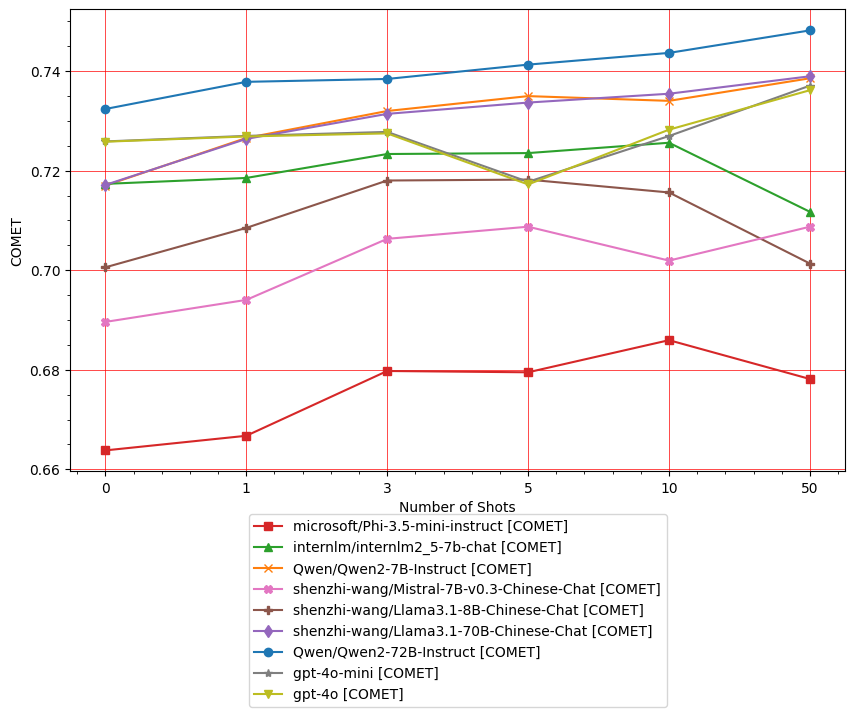

In [54]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["comet"],
    ["COMET"],
)

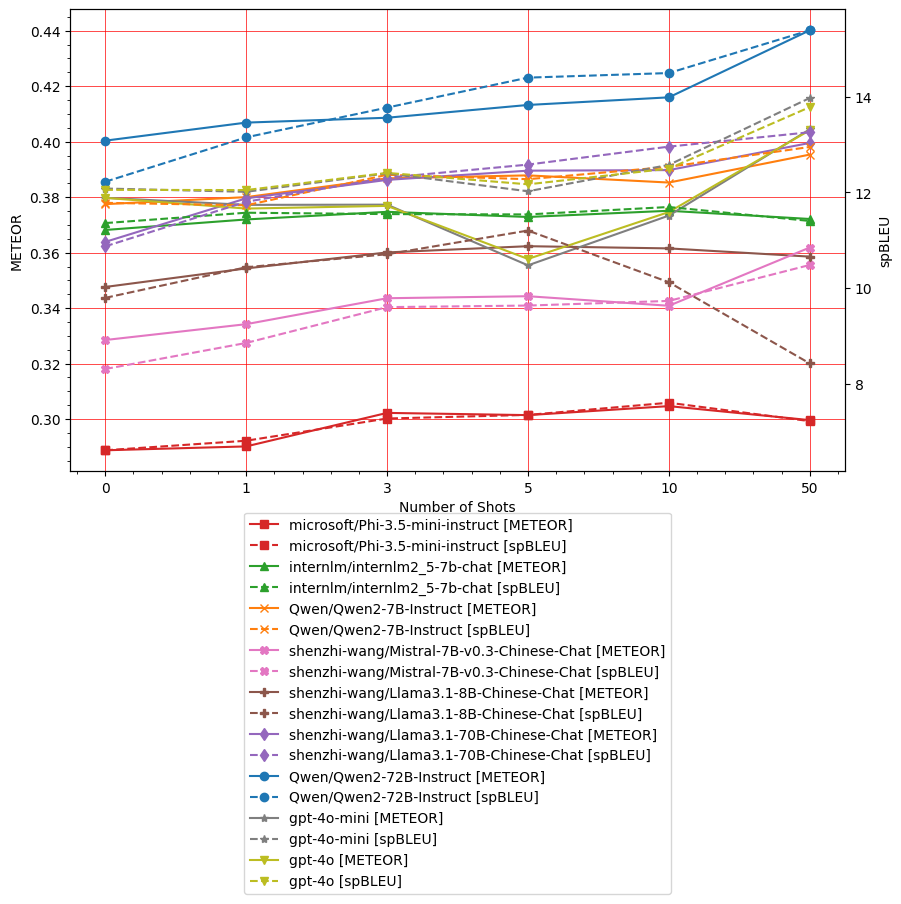

In [55]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["meteor", "spbleu"],
    ["METEOR", "spBLEU"],
)

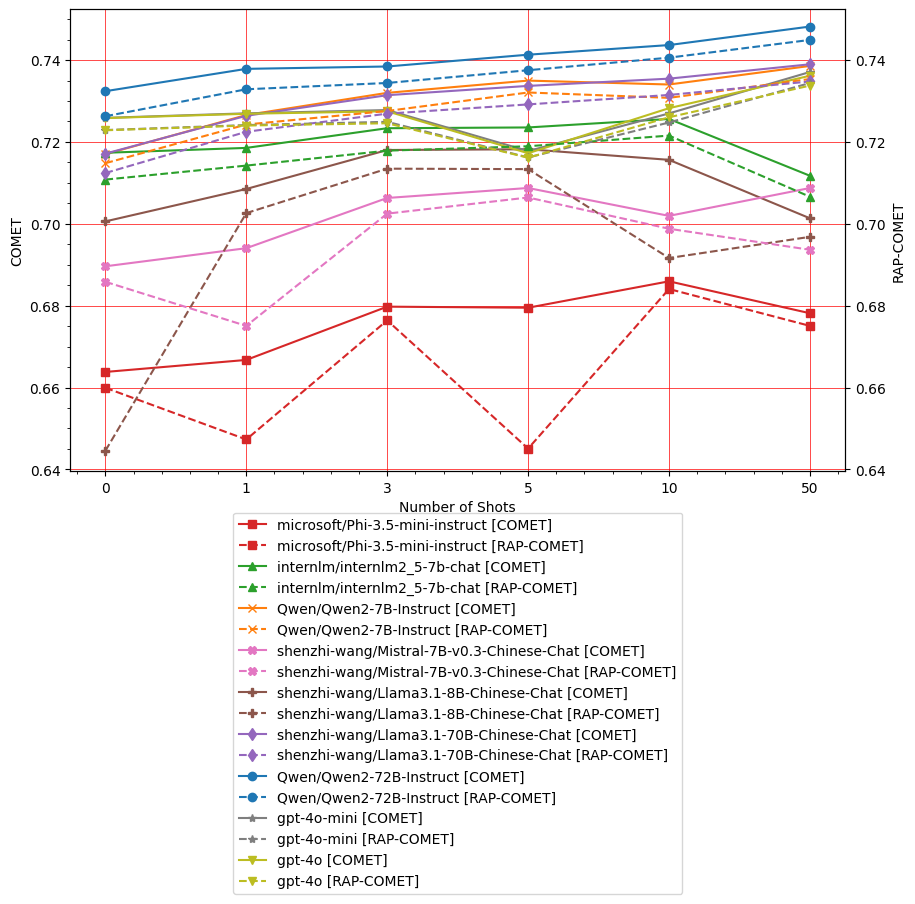

In [56]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["comet", "rap"],
    ["COMET", "RAP-COMET"],
    sync_y_axis=True,
)

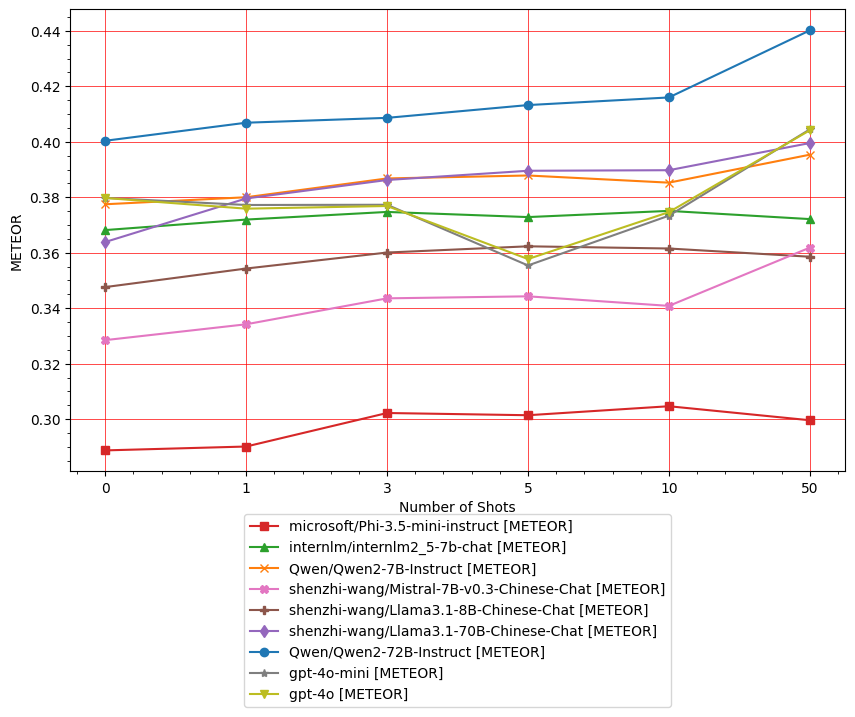

In [57]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["meteor"],
    ["METEOR"],
)

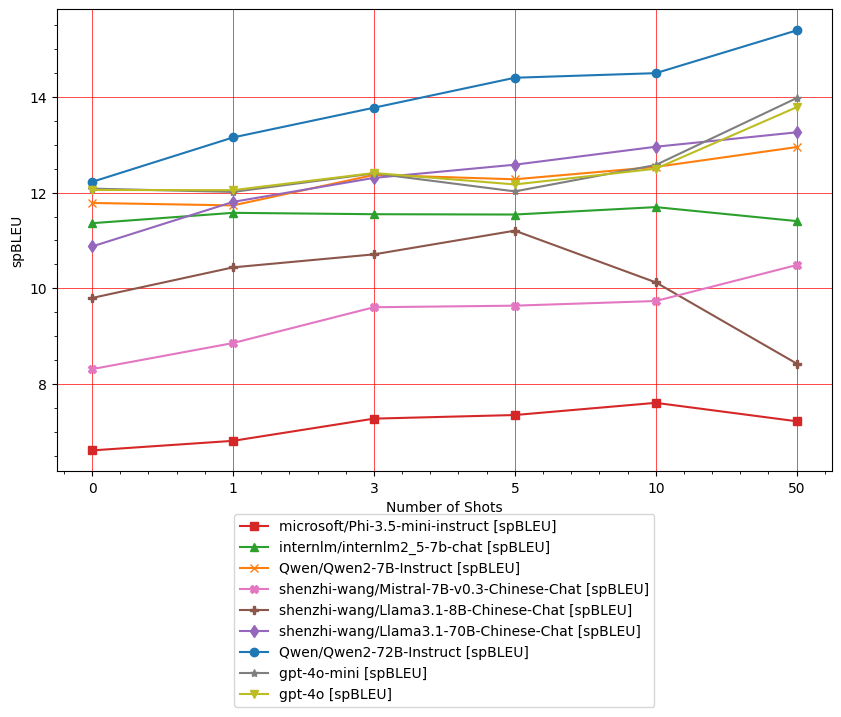

In [58]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["spbleu"],
    ["spBLEU"],
)

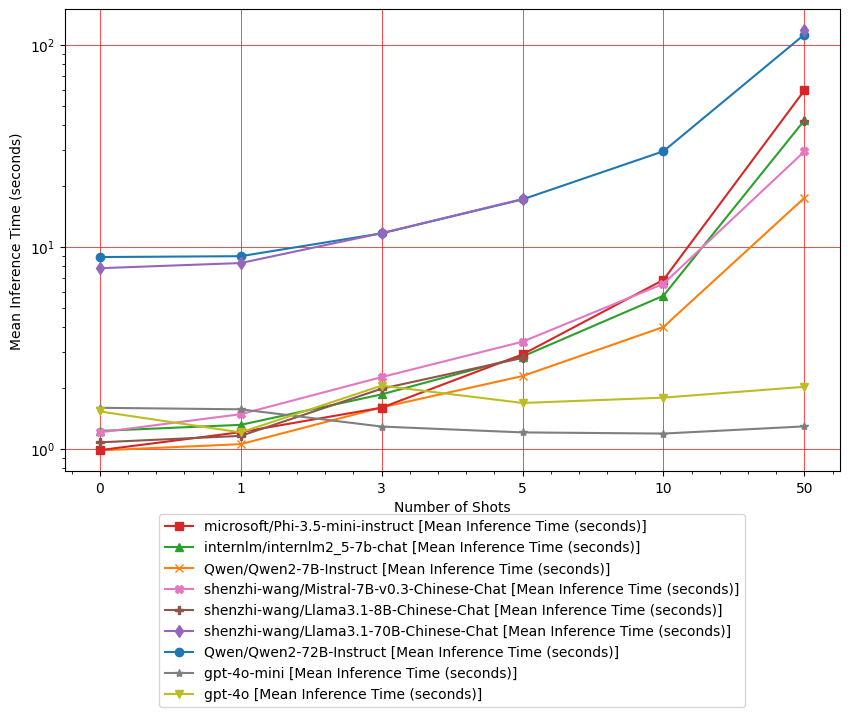

In [59]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["eval_time"],
    ["Mean Inference Time (seconds)"],
    [True],
)

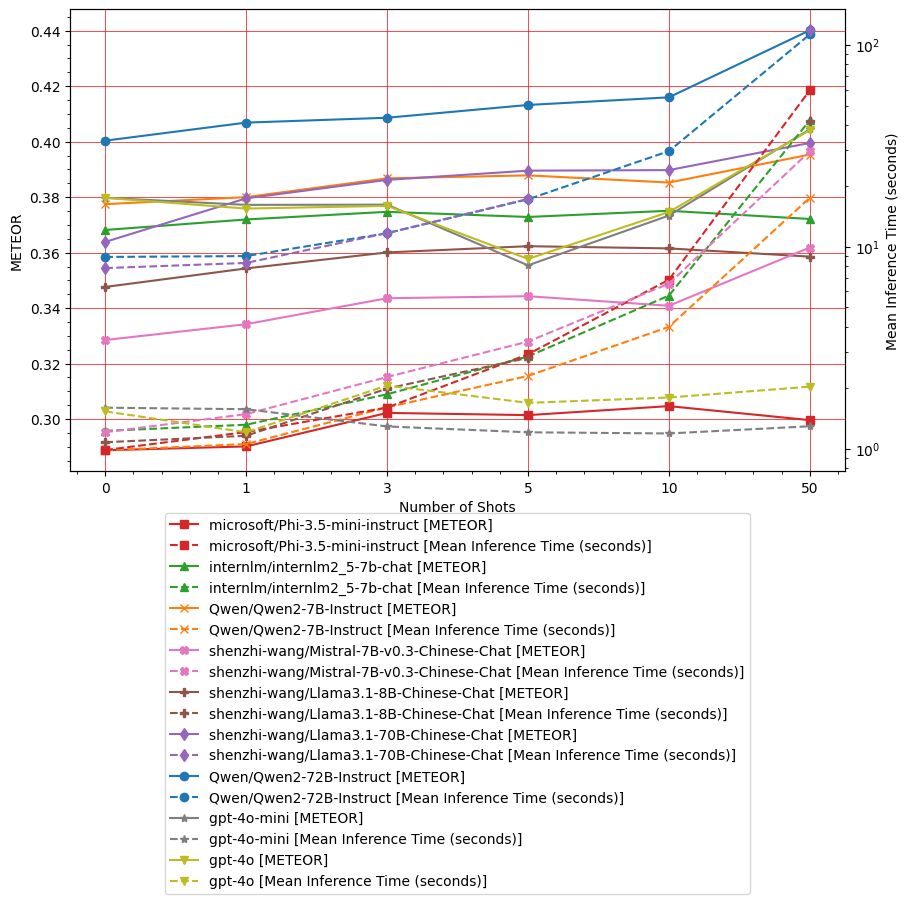

In [60]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["meteor", "eval_time"],
    ["METEOR", "Mean Inference Time (seconds)"],
    [False, True],
)

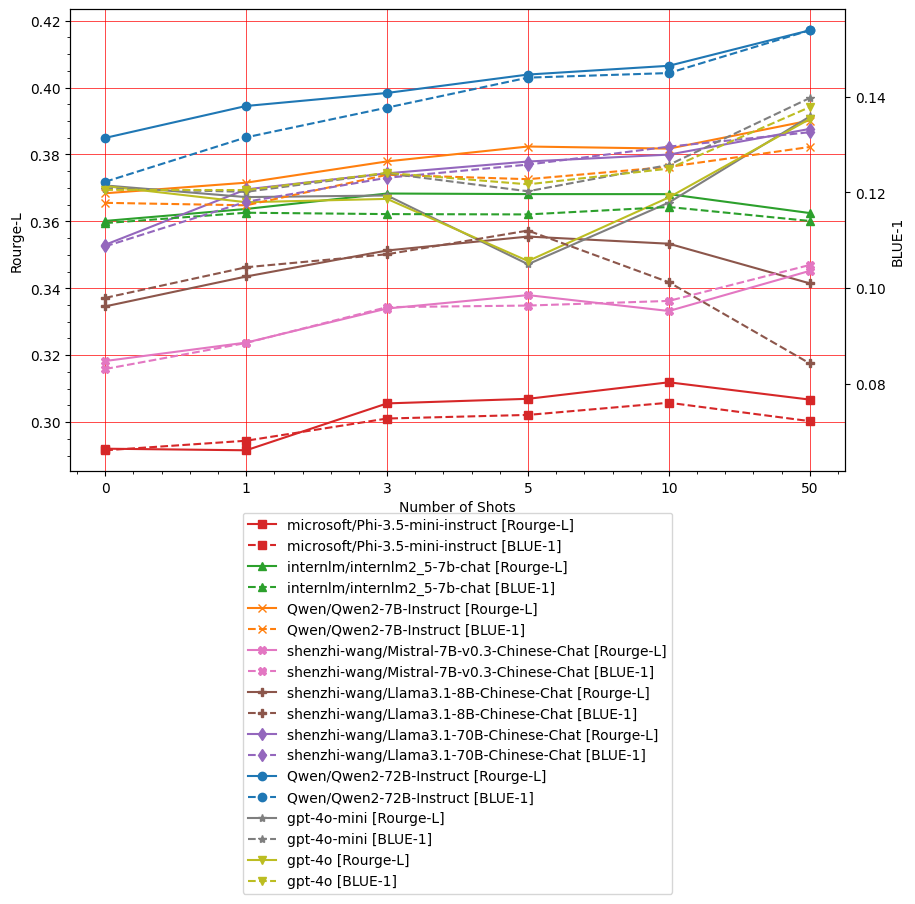

In [61]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["rouge_l", "bleu_1"],
    ["Rourge-L", "BLUE-1"],
)

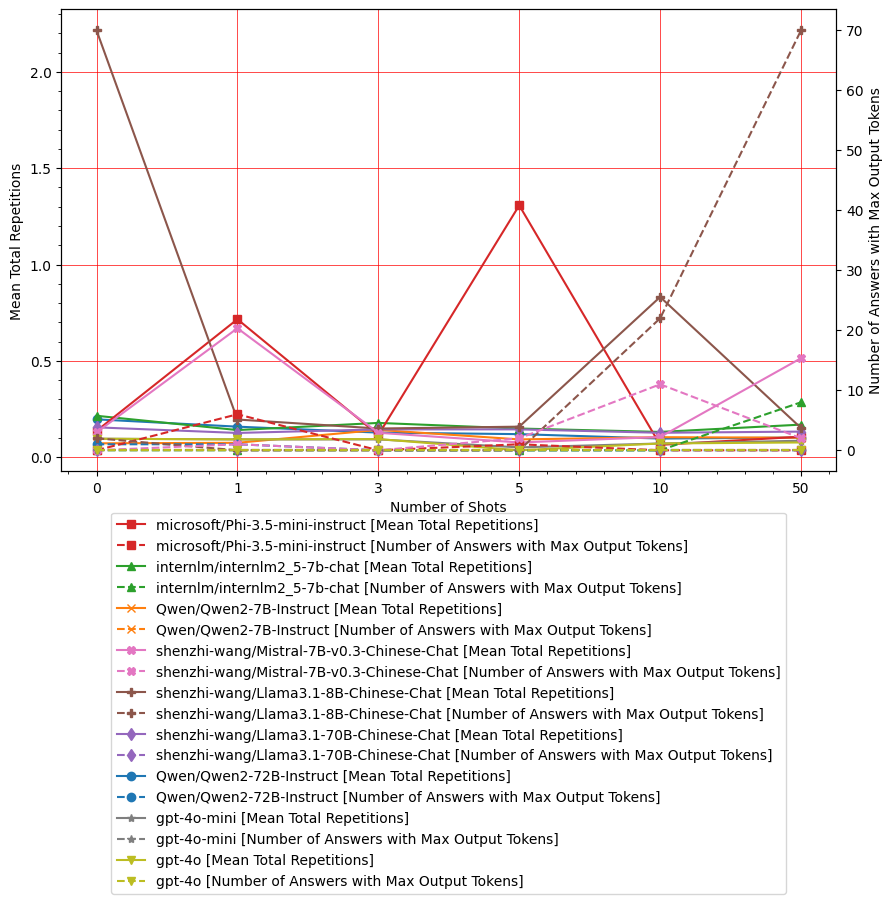

In [62]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["total_repetitions", "num_max_output_tokens"],
    ["Mean Total Repetitions", "Number of Answers with Max Output Tokens"],
)

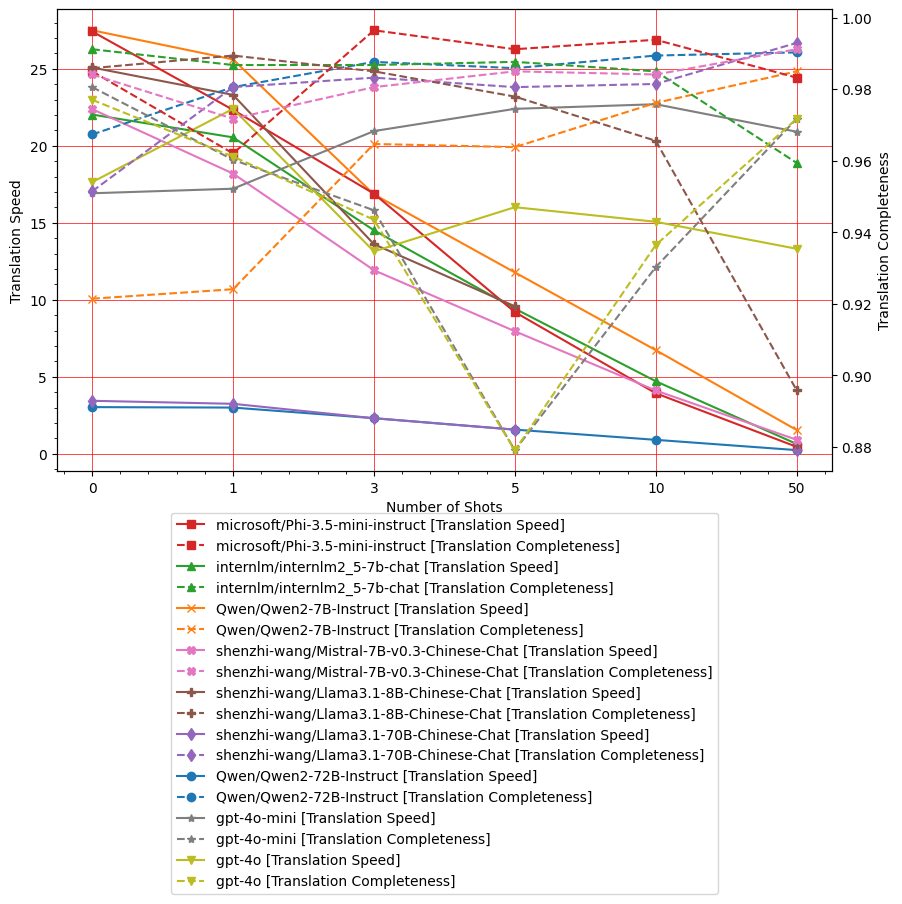

In [63]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["translation_speed", "translation_completeness"],
    ["Translation Speed", "Translation Completeness"],
)

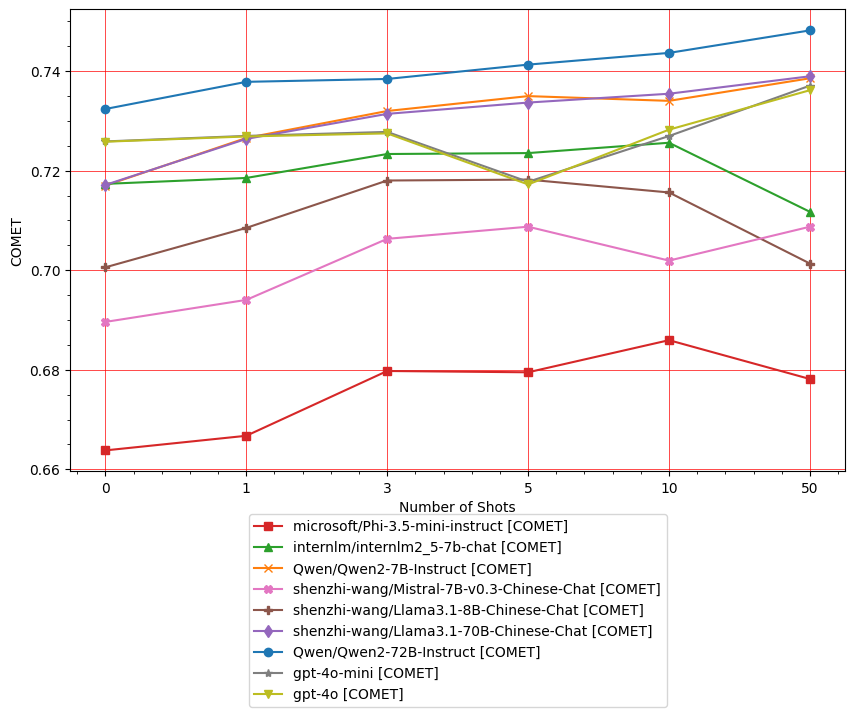

In [75]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["comet"],
    ["COMET"],
)

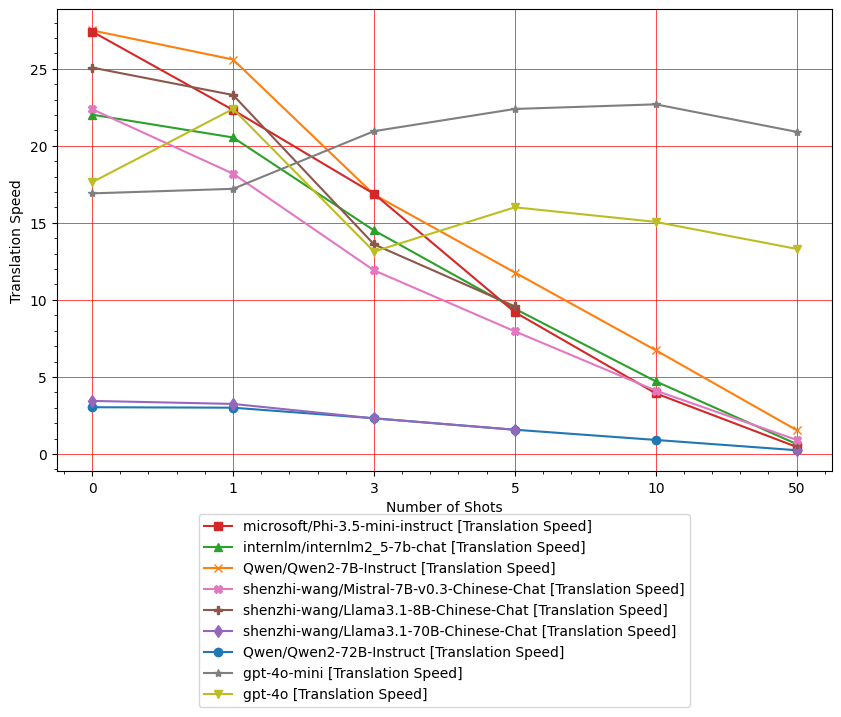

In [64]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["translation_speed"],
    ["Translation Speed"],
)

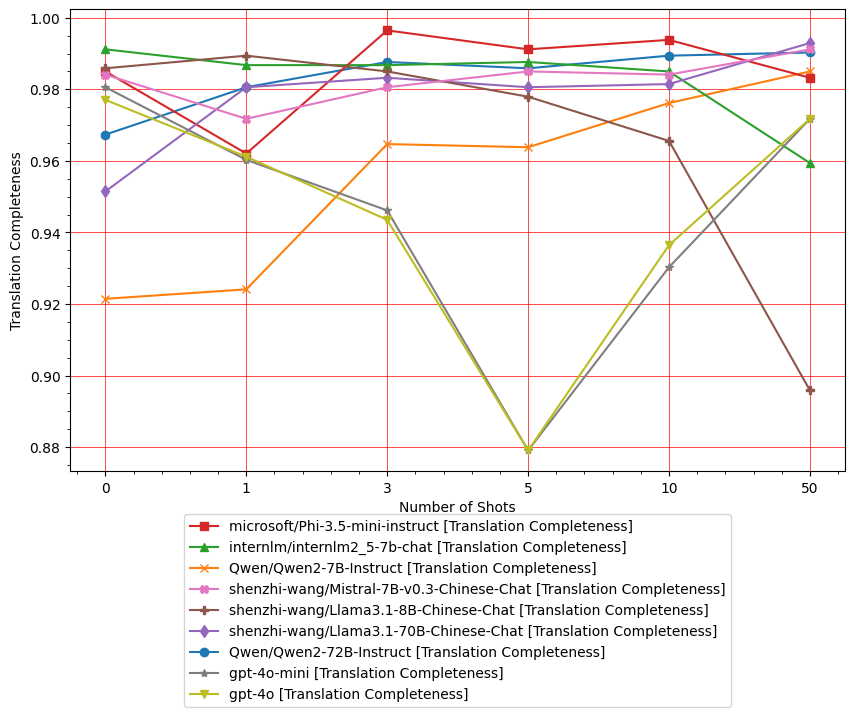

In [65]:
plot_metrics_vs_shots(
    metrics_df,
    models,
    markers,
    ["translation_completeness"],
    ["Translation Completeness"],
)

In [66]:
for col in result_columns:
    print(f"### Analyzing: {col}")
    analyze_translation_results(df, col, repetition_threshold=50)

### Analyzing: Qwen/Qwen2-72B-Instruct/shots-00
*** Found 0 rows with total_repetitions > 50 for Qwen/Qwen2-72B-Instruct/shots-00

*** Found 1 rows with output_tokens >= 300 for Qwen/Qwen2-72B-Instruct/shots-00
--------------------------------------------------
chinese: 话都说得有些不搭调，可也是借酒吐真言，放了平时则是难出口的。
--------------------------------------------------
english: Her words were inappropriate to the occasion; obviously, alcohol was bringing out some hidden truths.
--------------------------------------------------
Qwen/Qwen2-72B-Instruct/shots-00: Though his words were somewhat incoherent, he was speaking the truth by借助the aid of alcohol, which would be hard to utter under normal circumstances. 

Note: "借酒吐真言" is a Chinese idiom that means "to speak the truth with the aid of alcohol". However, since the instruction is not to provide additional sentences, I have included the translation of the idiom in brackets. If you prefer not to have this, the sentence would be: 

Though his words were s

In [67]:
metrics_df.to_csv(results_path.replace(".csv", "_metrics.csv"), index=False)

In [68]:
metrics_df.describe()

shots      comet     meteor     spbleu     bleu_1    rouge_l  \
count  54.000000  54.000000  54.000000  54.000000  54.000000  54.000000   
mean   11.500000   0.718116   0.367822  11.301196   0.113012   0.359572   
std    17.683539   0.019844   0.032843   2.067764   0.020678   0.029008   
min     0.000000   0.663802   0.288749   6.616686   0.066167   0.291578   
25%     1.000000   0.708746   0.355995  10.203512   0.102035   0.343949   
50%     4.000000   0.724580   0.374677  11.794467   0.117945   0.366952   
75%    10.000000   0.732299   0.386643  12.475866   0.124759   0.377925   
max    50.000000   0.748193   0.440154  15.386349   0.153863   0.417131   

       ews_score  repetition_score  total_repetitions        rap  \
count       54.0         54.000000          54.000000  54.000000   
mean         0.0          0.220245           0.220245   0.711775   
std          0.0          0.354235           0.354235   0.024613   
min          0.0          0.035305           0.035305   0.644550   
25%          0.0          0.092233           0.092233   0.702516   
50%          0.0          0.126214           0.126214   0.720248   
75%          0.0          0.153575           0.153575   0.727402   
max          0.0          2.216240           2.216240   0.744926   

       translation_completeness  num_max_output_tokens   eval_time  \
count                 54.000000              54.000000   52.000000   
mean                   0.969419               2.351852   11.914743   
std                    0.027456              10.021030   24.148014   
min                    0.879082               0.000000    0.980583   
25%                    0.962489               0.000000    1.306708   
50%                    0.980583               0.000000    2.157105   
75%                    0.985878               0.000000    8.917034   
max                    0.996470              70.000000  117.984113   

       translation_speed  
count          52.000000  
mean           11.928443  
std             8.891092  
min             0.228538  
25%             3.023910  
50%            12.529705  
75%            20.636125  
max            27.497750

In [69]:
df.describe()

ground_truth_ews_score  ground_truth_repetition_score  \
count                  1133.0                    1133.000000   
mean                      0.0                       0.312445   
std                       0.0                       7.193649   
min                       0.0                       0.000000   
25%                       0.0                       0.000000   
50%                       0.0                       0.000000   
75%                       0.0                       0.000000   
max                       0.0                     239.000000   

       ground_truth_total_repetitions  count_chinese_characters-ground_truth  \
count                     1133.000000                            1133.000000   
mean                         0.312445                              26.963813   
std                          7.193649                              19.069510   
min                          0.000000                               2.000000   
25%                          0.000000                              14.000000   
50%                          0.000000                              22.000000   
75%                          0.000000                              35.000000   
max                        239.000000                             143.000000   

       ews_score  repetition_score  total_repetitions  \
count     1133.0       1133.000000        1133.000000   
mean         0.0          0.075905           0.075905   
std          0.0          1.228156           1.228156   
min          0.0          0.000000           0.000000   
25%          0.0          0.000000           0.000000   
50%          0.0          0.000000           0.000000   
75%          0.0          0.000000           0.000000   
max          0.0         28.000000          28.000000   

       ground_truth_tokens-Qwen/Qwen2-72B-Instruct  \
count                                  1133.000000   
mean                                     29.458076   
std                                      20.126659   
min                                       1.000000   
25%                                      16.000000   
50%                                      25.000000   
75%                                      38.000000   
max                                     135.000000   

       count_chinese_characters-Qwen/Qwen2-72B-Instruct/shots-00  \
count                                        1133.000000           
mean                                            0.032657           
std                                             0.177815           
min                                             0.000000           
25%                                             0.000000           
50%                                             0.000000           
75%                                             0.000000           
max                                             1.000000           

       output_tokens-Qwen/Qwen2-72B-Instruct/shots-00  ...  \
count                                     1133.000000  ...   
mean                                        31.496911  ...   
std                                         24.337208  ...   
min                                          2.000000  ...   
25%                                         16.000000  ...   
50%                                         25.000000  ...   
75%                                         39.000000  ...   
max                                        300.000000  ...   

       count_chinese_characters-gpt-4o/shots-01  \
count                               1133.000000   
mean                                   0.038835   
std                                    0.193287   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    0.000000   
max                                    1.000000   

       output_tokens-gpt-4o/shots-01  \
count                    1133.000000